Expected mean interval: 1.00 seconds
Actual mean interval: 1.00 seconds


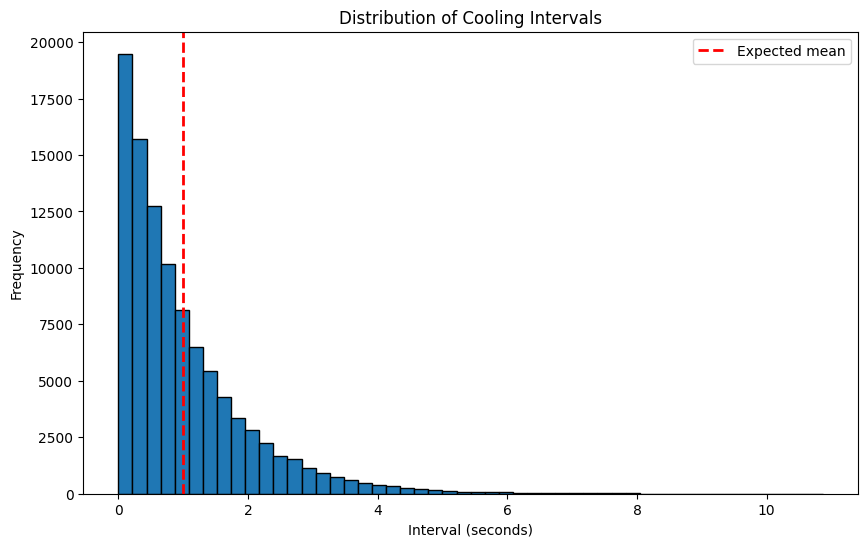

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Test parameters
activity_frequency = 1 # 0.1 actions per second on average

# Simulate cooling intervals
def cooling_interval(target):
    return np.random.gamma(shape=1, scale=1/target)

intervals = [cooling_interval(target=activity_frequency) for _ in range(100000)]

# Calculate statistics
mean_interval = np.mean(intervals)
expected_interval = 1 / activity_frequency

print(f"Expected mean interval: {expected_interval:.2f} seconds")
print(f"Actual mean interval: {mean_interval:.2f} seconds")

# Plot histogram of intervals
plt.figure(figsize=(10, 6))
plt.hist(intervals, bins=50, edgecolor='black')
plt.axvline(expected_interval, color='r', linestyle='dashed', linewidth=2, label='Expected mean')
plt.title('Distribution of Cooling Intervals')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Expected mean amount: 5.00
Actual mean amount: 5.00


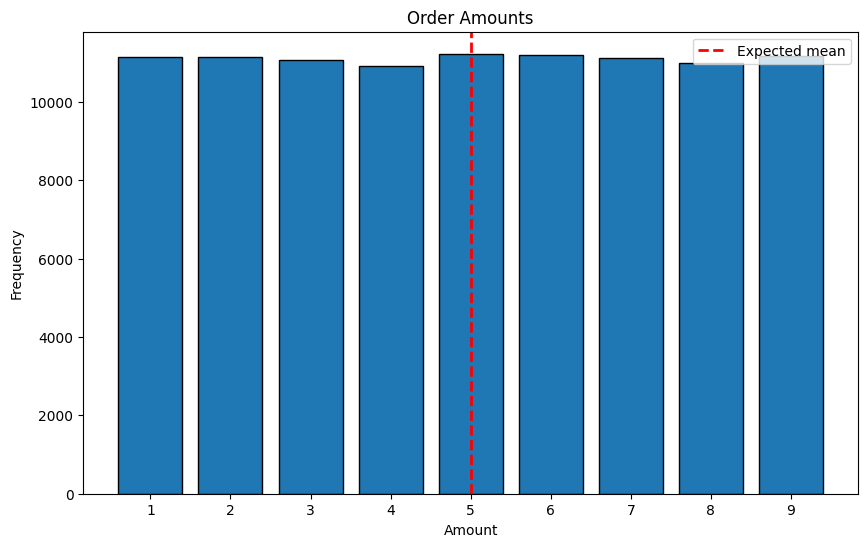

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Test parameters
order_amount = 9  # Maximum order amount
num_samples = 100000

# Simulate order amounts
amounts = [random.randint(1, order_amount) for _ in range(num_samples)]

# Calculate statistics
mean_amount = np.mean(amounts)
expected_mean = (1 + order_amount) / 2  # Expected mean of uniform distribution

print(f"Expected mean amount: {expected_mean:.2f}")
print(f"Actual mean amount: {mean_amount:.2f}")

# Plot histogram of amounts
plt.figure(figsize=(10, 6))
plt.hist(amounts, bins=range(1, order_amount + 2), align='left', rwidth=0.8, edgecolor='black')
plt.axvline(expected_mean, color='r', linestyle='dashed', linewidth=2, label='Expected mean')
plt.title('Order Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.xticks(range(1, order_amount + 1))
plt.legend()
plt.show()